In [2]:
import yfinance as yf

def get_itc_stock_data(start_date, end_date):
    # Ticker symbol for ITC
    symbol = "ITC.NS"  # ".NS" is the suffix for stocks listed on the NSE (National Stock Exchange) in India

    # Fetch historical data using yfinance
    itc_data = yf.download(symbol, start=start_date, end=end_date)

    return itc_data

# Specify the start and end dates for the data
start_date = "2014-01-01"
end_date = "2024-01-01"

# Get ITC stock data
itc_stock_data = get_itc_stock_data(start_date, end_date)

# Display the obtained data
itc_stock_data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-01,214.866669,215.600006,214.066666,214.933334,164.885651,1859278
2014-01-02,214.899994,216.666672,209.533340,209.966660,161.075485,6784786
2014-01-03,210.000000,210.666672,206.899994,209.833328,160.973175,11999877
2014-01-06,210.000000,211.133331,209.000000,210.433334,161.433472,8155128
2014-01-07,211.000000,211.600006,208.500000,211.133331,161.970474,7779138


In [3]:
# Keep only the "Close" column
itc_stock_data = itc_stock_data[['Close']]

# Display the modified DataFrame
print(itc_stock_data.head())


                 Close
Date                  
2014-01-01  214.933334
2014-01-02  209.966660
2014-01-03  209.833328
2014-01-06  210.433334
2014-01-07  211.133331


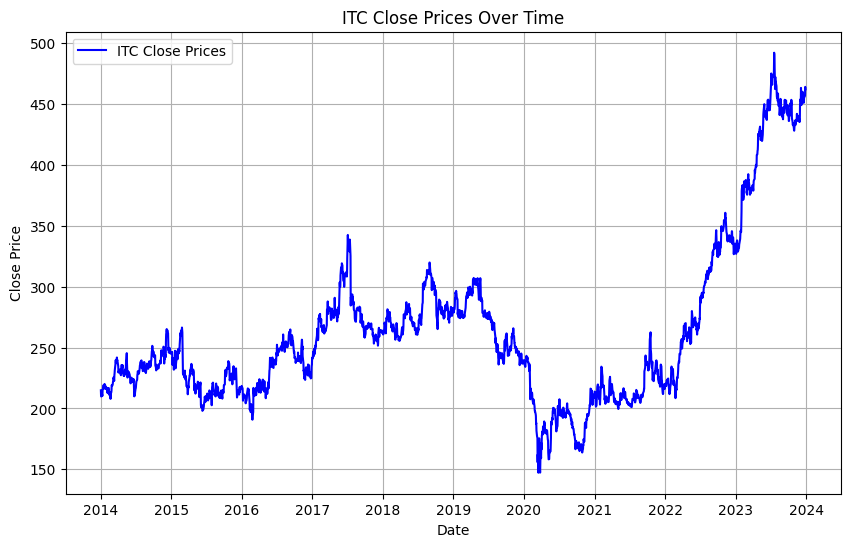

In [4]:
import matplotlib.pyplot as plt

# Plotting the Close prices
plt.figure(figsize=(10, 6))
plt.plot(itc_stock_data.index, itc_stock_data['Close'], label='ITC Close Prices', color='blue')
plt.title('ITC Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50
62/62 [==============================] - 7s 12ms/step - loss: 0.0111
Epoch 2/50
62/62 [==============================] - 1s 12ms/step - loss: 6.5512e-04
Epoch 3/50
62/62 [==============================] - 1s 12ms/step - loss: 5.4930e-04
Epoch 4/50
62/62 [==============================] - 1s 12ms/step - loss: 5.4598e-04
Epoch 5/50
62/62 [==============================] - 1s 12ms/step - loss: 5.3825e-04
Epoch 6/50
62/62 [==============================] - 1s 16ms/step - loss: 5.6409e-04
Epoch 7/50
62/62 [==============================] - 1s 18ms/step - loss: 5.2166e-04
Epoch 8/50
62/62 [==============================] - 1s 21ms/step - loss: 5.1669e-04
Epoch 9/50
62/62 [==============================] - 1s 18ms/step - loss: 5.0515e-04
Epoch 10/50
62/62 [==============================] - 1s 16ms/step - loss: 5.0109e-04
Epoch 11/50
62/62 [==============================] - 1s 12ms/step - loss: 4.7231e-04
Epoch 12/50
62/62 [==============================] - 1s 12ms/step - loss: 4.56

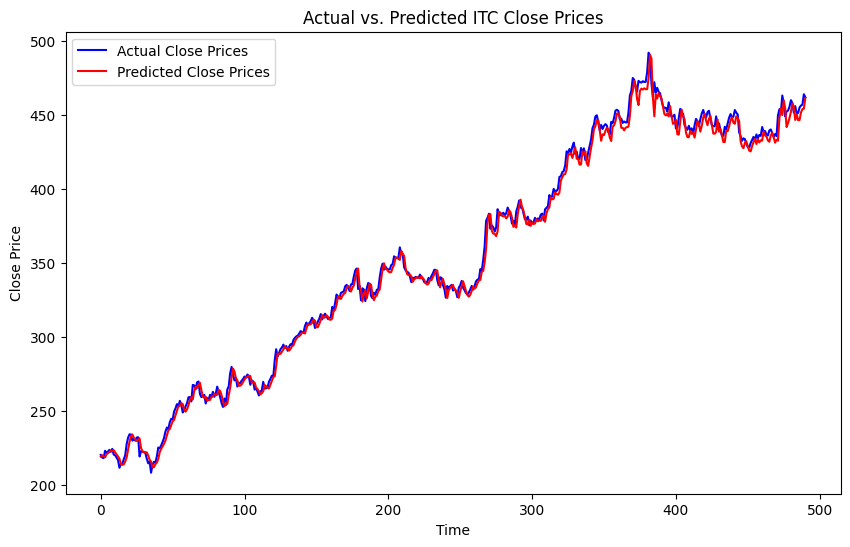

Mean Absolute Error (MAE): 3.8571963183991533


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Ensure that the itc_stock_data DataFrame is loaded and contains the 'Close' column
# If not, you can load it using the previous code

# Extract the 'Close' prices
close_prices = itc_stock_data['Close'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

# Function to prepare the dataset for LSTM
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

# Set the time steps for the LSTM model
time_steps = 10

# Create the dataset
X, y = create_dataset(close_prices_scaled, time_steps)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape the input data for LSTM (number of samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Invert the scaling for predictions
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs. predicted closing prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Close Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Close Prices', color='red')
plt.title('Actual vs. Predicted ITC Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f'Mean Absolute Error (MAE): {mae}')


In [9]:
# Create a DataFrame with predicted and actual values
results_df = pd.DataFrame({'Actual Close': y_test_actual.flatten(), 'Predicted Close': y_pred_actual.flatten()})

# Display the DataFrame
results_df.tail()

,Actual Close,Predicted Close
486,455.200012,446.654480
487,456.450012,451.811066
488,457.100006,454.096130
489,464.100006,454.370972
490,462.100006,461.479919


In [8]:
# Predict the next one day Close price
last_time_steps_data = close_prices[-time_steps:]
last_time_steps_data_scaled = scaler.transform(last_time_steps_data.reshape(-1, 1))

# Reshape the data for prediction
input_data = last_time_steps_data_scaled.reshape(1, time_steps, 1)

# Make the prediction
predicted_scaled = model.predict(input_data)

# Invert the scaling for the predicted value
predicted_close = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

print(f'Predicted Close for the next day: {predicted_close[0][0]}')

1/1 [==============================] - 0s 54ms/step
Predicted Close for the next day: 459.20379638671875


In [12]:
# Predict the next 30 days Close prices
predictions = []

for _ in range(30):
    # Take the last time_steps days as input
    last_time_steps_data = close_prices[-time_steps:]
    last_time_steps_data_scaled = scaler.transform(last_time_steps_data.reshape(-1, 1))

    # Reshape the data for prediction
    input_data = last_time_steps_data_scaled.reshape(1, time_steps, 1)

    # Make the prediction
    predicted_scaled = model.predict(input_data)

    # Invert the scaling for the predicted value
    predicted_close = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

    # Append the predicted value to the list of predictions
    predictions.append(predicted_close[0, 0])

    # Update the input data for the next iteration
    close_prices = np.append(close_prices, predicted_close, axis=0)

# Create a DataFrame with the predicted values
predicted_df = pd.DataFrame({'Predicted Close': predictions})

# Display the DataFrame
predicted_df

1/1 [==============================] - 0s 22ms/step


,Predicted Close
0,459.203796
1,454.113831
2,447.652771
3,440.550293
4,433.704193
5,427.751526
6,423.054474
7,419.739807
8,417.681976
9,416.463531
